### Dependencies

In [1]:
import sys, os
from csv import DictWriter

import numpy as np
import pandas as pd
import torch as T
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from scipy.signal import detrend

import pynumdiff

from dataclasses import dataclass

import torch_optimizer as optim_all

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
plt.style.use("seaborn-v0_8-whitegrid")

### Physical Model

In [2]:
def build_true_model(x, t, params):
    """
    A function that gets the displacement, velocity and time as an input, and returns the true vector field output (velocity and acceleration)

    Parameters
    ----------
    x : numpy.ndarray 
        a 2D array containing the displacement in the first column and the velocity in the second one
    t : numpy.ndarray
        an 1D array containing the discrete time values 
    params : parameters dataclass
        the parameters of the run
    Returns
    -------
    numpy.ndarray
        a 2D array with the two vector field values, velocity as first column and acceleration as second, for the given input x and t
    """

    # Check if there is sticking - Zero velocity and friction force bigger than the opposing forces
    if np.abs(x[1]) < 1e-5 and np.abs(params.F0 * np.cos(params.forcing_freq * t) - params.stiffness * x[0]) <= params.friction_force_ratio * params.F0:
        return np.array([0., 0.])
    else:
        return np.array([x[1], - 2 * params.zeta * params.omega * x[1] - params.omega ** 2 * x[0] - params.friction_force_ratio * np.sign(x[1]) + params.F0 * np.cos(params.forcing_freq * t)])
    

In [3]:
def generate_data(params):
    """
    A function that solves the system's equation and generates the ground truth data based on the defined run parameters

    Parameters
    ----------
    params : parameters dataclass
        the parameters of the run
    Returns
    -------
    numpy.ndarray
        an 1D array with the discrete time instances
    numpy.ndarray
        a 2D array with the ground truth data, displacements as first column and velocities as second
    """
    #Generate (noisy) measurements - Training Data
    ts = np.arange(0, params.timefinal, params.timestep)

    # Make sure that in case of a free vibration analysis, friction and forcing terms are dropped
    if params.analysis_type == "free":
        params.friction_force_ratio = 0
        params.F0 = 0

    # Solve the equation
    sol = solve_ivp(
        lambda t, x: build_true_model(x, t, params), 
        t_span=[ts[0], ts[-1]], y0=params.x0, t_eval=ts
        )

    return ts, np.transpose(sol.y)

### Get measurments from csv file

In [4]:
def get_measurments(csv_path, rows_skip=4, detrend_flag=True, delta_T=30):
    """
    A function that reads the csv file containing the experimental data and returns the absolute and relative displacements 

    Parameters
    ----------
    csv_path : str 
        the path of the csv file
    rows_skip : int
        the number of rows in the csv that does not contain any data (header)
    detrend_flag : bool
        a flag that if set to True (default value) the data will be editted to remove a rigid body contribution
    delta_T : int
        a time increment in case the timestamp does not start from zero
    Returns
    -------
    numpy.ndarray
        an 1D array containing the absolute displacements
    numpy.ndarray
        an 1D array containing the relative displacements
    """
    data = pd.read_csv(csv_path, skiprows=rows_skip)
    
    if delta_T:
        data.iloc[:, 0] -= 30
    
    excitMil = data.iloc[:, 1].to_numpy()
    displsMil = data.iloc[:, 2].to_numpy()

    # change the units into meters
    displs = displsMil * 0.001
    excite = excitMil * 0.001
    
    startExcitation = np.nonzero(np.abs(displs - displs[0]) >= 1e-6)[0][0]
    displs = displs[startExcitation:]
    excite = excite[startExcitation:]

    if detrend_flag:
        displs = detrend(displs, type='constant')
        excite = detrend(excite, type='constant')

    return displs, excite

### Get the excitation frequency content (through the Forward Fourier Transform)

In [5]:
def get_frequency_content(displs, no_sample_points, sample_spacing):
    """
    A function that applies the Forward Fourier Transform to decompose the signal into its frequency content 

    Parameters
    ----------
    displs : numpy.ndarray 
        an 1D array containing the displacements (response quantity)
    no_sample_points : int
        the number of sample points that will be used
    sample_spacing : float
        the size of the sampling intervals
    Returns
    -------
    numpy.ndarray
        the involved frequencies
    numpy.ndarray
        the spectral density of each of the frequencies
    """
    yf = fft(displs)
    freqs = fftfreq(no_sample_points, sample_spacing)[: no_sample_points // 2]
    spectral_density = 2.0 / no_sample_points * np.abs(yf[0 : no_sample_points // 2])

    return freqs, spectral_density

### Coefficients dictionary

In [6]:
class CoeffsDictionary(T.nn.Module):
    """
    A class for initializing, storing, and updating the ksi coefficients
    These coefficients are the linear weights of a neural network
    The class inherits from the torch.nn.Module
    """
    def __init__(self, n_combinations):

        super(CoeffsDictionary, self).__init__()
        self.linear = T.nn.Linear(n_combinations, 1, bias=False)
        # Setting the weights to zeros
        self.linear.weight = T.nn.Parameter(0 * self.linear.weight.clone().detach())
    
    def forward(self, x):
        
        return self.linear(x)

### Features function

In [7]:
def apply_features(x, t, params, torch_flag=True):
    """
    Applies the feature candidates to the given data

    Parameters
    ----------
    x : numpy.ndarray or torch.Tensor
        a 2D array/tensor containing the displacement in the first column and the velocity in the second one
    t : numpy.ndarray or torch.Tensor
        an 1D array/tensor containing the discrete time values 
    params : parameters dataclass
        the parameters of the run
    torch_flag : bool
        if True, the type of x, t and return object is torch.Tensor, otherwise numpy.ndarray
    Returns
    -------
    numpy.ndarray or torch.Tensor
        a 2D array/tensor with the two vector field values, velocity as first column and acceleration as second, 
        applying the assumed features on the given input x and t
    
    """
    if torch_flag:
        return T.column_stack(
            (
                *[T.cos(ph * t) for ph in params.cos_phases], # cosine features
                *[T.sin(ph * t) for ph in params.sin_phases], # sine features
                *[T.sign(x[:, 0]),] * params.x_sgn_flag, # x signum feature
                *[T.sign(x[:, 1]),] * params.y_sgn_flag, # y signum feature
                *[T.log((T.abs(x[:, 1]) + 1e-6) / 3e-3),] * params.log_1, # natural log of abs vel
                *[T.log(0.022 + 3e-3 / (T.abs(x[:, 1]) + 1e-6)),] * params.log_2, # natural log of abs displ
                *[T.ones(size=(x.shape[0],))] * (params.poly_order >= 0), 
                *[x[:, 0], x[:, 1]] * (params.poly_order >= 1),
                *[x[:, 0] ** 2, x[:, 0] * x[:, 1], x[:, 1] ** 2] * (params.poly_order >= 2),
                *[x[:, 0] ** 3, x[:, 0] ** 2 * x[:, 1], x[:, 0] * x[:, 1] ** 2, x[:, 1] ** 3,] * (params.poly_order >= 3),
                *[x[:, 0] ** 4, x[:, 0] ** 3 * x[:, 1], x[:, 0] ** 2 * x[:, 1] ** 2, x[:, 0] * x[:, 1] ** 3, x[:, 1] ** 4] * (params.poly_order >= 4), # polynomial features
            )
        )
    else:
        return np.column_stack(
            (
                *[np.cos(ph * t) for ph in params.cos_phases], # cosine features                
                *[np.sin(ph * t) for ph in params.sin_phases], # sine features                
                *[np.sign(x[:, 0]),] * params.x_sgn_flag, # x signum feature 
                *[np.sign(x[:, 1]),] * params.y_sgn_flag, # y signum feature
                *[np.log((np.abs(x[:, 1]) + 1e-6) / 3e-3),] * params.log_1, # natural log of abs vel
                *[np.log(0.022 + 3e-3 / (np.abs(x[:, 1]) + 1e-6)),] * params.log_2, # natural log of abs displ
                *[np.ones(shape=(x.shape[0],))] * (params.poly_order >= 0), 
                *[x[:, 0], x[:, 1]] * (params.poly_order >= 1),
                *[x[:, 0] ** 2, x[:, 0] * x[:, 1], x[:, 1] ** 2] * (params.poly_order >= 2),
                *[x[:, 0] ** 3, x[:, 0] ** 2 * x[:, 1], x[:, 0] * x[:, 1] ** 2, x[:, 1] ** 3,] * (params.poly_order >= 3),
                *[x[:, 0] ** 4, x[:, 0] ** 3 * x[:, 1], x[:, 0] ** 2 * x[:, 1] ** 2, x[:, 0] * x[:, 1] ** 3, x[:, 1] ** 4] * (params.poly_order >= 4), # polynomial features
            )
        )


#### Store the selected features as strings in a list

In [8]:
def get_feature_names(params):
    """"
    A function that stores the assumed features as strings

    Parameters
    ----------
    params : parameters dataclass
        the parameters of the run

    Returns
    -------
    list
        the list containing the assumed features as strings
    """
    return [*[f"cos({ph:.1f} t)" for ph in params.cos_phases], 
            *[f"sin({ph:.1f} t)" for ph in params.sin_phases], 
            *["sgn(x)",] * params.x_sgn_flag,
            *["sgn(y)",] * params.y_sgn_flag,
            *["ln((|y| + eps) / V*)",] * params.log_1,
            *["ln(c + V* / (|y| + eps))",] * params.log_2,
            *["1",] * (params.poly_order >= 0),
            *["x", "y"] * (params.poly_order >= 1),
            *["x^2", "xy", "y^2"] * (params.poly_order >= 2),
            *["x^3", "x^2y", "xy^2", "y^3"] * (params.poly_order >= 3),
            *["x^4", "x^3y", "x^2y^2", "xy^3", "y^4"] * (params.poly_order >= 4),]

#### Print the learnt equation

In [9]:
def print_learnt_equation(learnt_coeffs, params):
    """"
    A function that combines the learnt coefficients and the assumed features 
    to form the governing equation

    Parameters
    ----------
    learnt_coeffs : numpy.ndarray
        an array containing the learnt coefficients
    params : parameters dataclass
        the parameters of the run

    Returns
    -------
    str
        the governing equation
    """
    feature_names = get_feature_names(params)
    
    string_list = [f'{"+" if coeff > 0  else ""}{coeff:.3f} {feat}' for coeff, feat in zip(np.squeeze(learnt_coeffs, axis=1), feature_names) if np.abs(coeff) > 1e-5]

    equation = " ".join(string_list)

    if equation[0] == "+":
        equation = equation[1:]
    
    return equation 

### Ground truth
$$\ddot{x} = -386.36 \,x - 0.0658\, \dot{x} -0.0856\, \mathrm{sgn}(y) + 386.36 \,u + 0.0658\, \dot{u}$$

In [10]:
def apply_rk4_SparseId(x, u_1, u_m, u_2, coeffs, times, timesteps, params):
    """
    A function that applies the fourth order Runge-Kutta scheme to the given data in order to derive the ones in the following timestep
    During this process the approximate derivatives are used
   
    Parameters
    ----------
    x : torch.Tensor
        a 2D tensor containing the displacement in the first column and the velocity in the second one
    coeffs : CoeffsDictionary object
        the neural network with the sought coefficients as its weights
    times : torch.Tensor
        an 1D tensor containing the discrete time values
    timesteps : torch.Tensor
        an 1D tensor containing the discrete time intervals
    params : parameters dataclass
        the parameters of the run

    Returns
    -------
    torch.Tensor
        Predictions of both displacement and velocity for the next timesteps
    
    """

    d1 = apply_features(x, times, params)
    k1 = T.column_stack((x[:, 1].unsqueeze(1), (- 386.36 * x[:, 0] 
                                                - 0.0658 * x[:, 1]
                                                + 386.36 * u_1[:, 0] 
                                                + 0.0658 * u_1[:, 1]
                                                ).unsqueeze(1) + coeffs(d1) * T.sign(x[:, 1]).unsqueeze(1)))
    
    # k1 = T.where((T.abs(x[:, 1]).unsqueeze(1) <= 1e-4) & ((T.abs(358.706 * u_1[:, 0]) + T.abs(0.0658 * u_1[:, 1])- T.abs(358.706 * x[:, 0])).unsqueeze(1) <= T.abs(coeffs(d1))), 0., k1)
    # k1 = T.where((T.abs(x[:, 1]).unsqueeze(1) <= 1e-5) & (T.abs(358.706 * u_1[:, 0] + 0.0658 * u_1[:, 1]- 358.706 * x[:, 0]).unsqueeze(1) <= T.abs(coeffs(d1))), 0., k1)
    k1 = T.where((T.abs(x[:, 1]).unsqueeze(1) <= params.stick_tol), 0., k1)
    
    xtemp = x + 0.5 * timesteps * k1
    d2 = apply_features(xtemp, times + 0.5 * timesteps, params)
    k2 = T.column_stack((xtemp[:, 1].unsqueeze(1), (- 386.36 * xtemp[:, 0] 
                                                    - 0.0658 * xtemp[:, 1]
                                                    + 386.36 * u_m[:, 0] 
                                                    + 0.0658 * u_m[:, 1]
                                                    ).unsqueeze(1) + coeffs(d2) * T.sign(xtemp[:, 1]).unsqueeze(1)))

    # k2 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= 1e-4) & ((T.abs(358.706 * u_m[:, 0]) + T.abs(0.0658 * u_m[:, 1]) - T.abs(358.706 * xtemp[:, 0])).unsqueeze(1) <= T.abs(coeffs(d2))), 0., k2)
    # k2 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= 1e-5) & (T.abs(358.706 * u_m[:, 0] + 0.0658 * u_m[:, 1] - 358.706 * xtemp[:, 0]).unsqueeze(1) <= T.abs(coeffs(d2))), 0., k2)
    k2 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= params.stick_tol), 0., k2)

    xtemp = x + 0.5 * timesteps * k2
    d3 = apply_features(xtemp, times + 0.5 * timesteps, params)
    k3 = T.column_stack((xtemp[:, 1].unsqueeze(1), (- 386.36 * xtemp[:, 0] 
                                                    - 0.0658 * xtemp[:, 1]
                                                    + 386.36 * u_m[:, 0] 
                                                    + 0.0658 * u_m[:, 1]
                                                    ).unsqueeze(1) + coeffs(d3) * T.sign(xtemp[:, 1]).unsqueeze(1)))
    # k3 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= 1e-4) & ((T.abs(358.706 * u_m[:, 0]) + T.abs(0.0658 * u_m[:, 1]) - T.abs(358.706 * xtemp[:, 0])).unsqueeze(1) <= T.abs(coeffs(d3))), 0., k3)
    # k3 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= 1e-5) & (T.abs(358.706 * u_m[:, 0] + 0.0658 * u_m[:, 1] - 358.706 * xtemp[:, 0]).unsqueeze(1) <= T.abs(coeffs(d3))), 0., k3)
    k3 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= params.stick_tol), 0., k3)


    xtemp = x + timesteps * k3
    d4 = apply_features(xtemp, times + timesteps, params)
    k4 = T.column_stack((xtemp[:, 1].unsqueeze(1), (- 386.36 * xtemp[:, 0] 
                                                    - 0.0658 * xtemp[:, 1]
                                                    + 386.36 * u_2[:, 0] 
                                                    + 0.0658 * u_2[:, 1]
                                                    ).unsqueeze(1) + coeffs(d4) * T.sign(xtemp[:, 1]).unsqueeze(1)))
    # k4 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= 1e-4) & ((T.abs(358.706 * u_2[:, 0]) + T.abs(0.0658 * u_2[:, 1]) - T.abs(358.706 * xtemp[:, 0])).unsqueeze(1) <= T.abs(coeffs(d4))), 0., k4)
    # k4 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= 1e-5) & (T.abs(358.706 * u_2[:, 0] + 0.0658 * u_2[:, 1] - 358.706 * xtemp[:, 0]).unsqueeze(1) <= T.abs(coeffs(d4))), 0., k4)
    k4 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= params.stick_tol), 0., k4)

    return x + (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4) * timesteps

In [11]:
def apply_rk4_SparseId_2(x, u_1, u_m, u_2, coeffs, times, timesteps, params):
    """
    A function that applies the fourth order Runge-Kutta scheme to the given data in order to derive the ones in the following timestep
    During this process the approximate derivatives are used
   
    Parameters
    ----------
    x : torch.Tensor
        a 2D tensor containing the displacement in the first column and the velocity in the second one
    coeffs : CoeffsDictionary object
        the neural network with the sought coefficients as its weights
    times : torch.Tensor
        an 1D tensor containing the discrete time values
    timesteps : torch.Tensor
        an 1D tensor containing the discrete time intervals
    params : parameters dataclass
        the parameters of the run

    Returns
    -------
    torch.Tensor
        Predictions of both displacement and velocity for the next timesteps
    
    """

    d1 = apply_features(x, times, params)
    k1 = T.column_stack((x[:, 1].unsqueeze(1), (- 386.36 * x[:, 0] 
                                                - 0.0658 * x[:, 1]
                                                # + 386.36 * u_1[:, 0] 
                                                # + 0.0658 * u_1[:, 1]
                                                # ).unsqueeze(1) + coeffs(d1) * T.sign(x[:, 1]).unsqueeze(1)))
                                                + params.F0 * T.cos(params.forcing_freq * times.squeeze(1))
                                                ).unsqueeze(1) + coeffs(d1)))
    
    # k1 = T.where((T.abs(x[:, 1]).unsqueeze(1) <= 1e-4) & ((T.abs(358.706 * u_1[:, 0]) + T.abs(0.0658 * u_1[:, 1])- T.abs(358.706 * x[:, 0])).unsqueeze(1) <= T.abs(coeffs(d1))), 0., k1)
    # k1 = T.where((T.abs(x[:, 1]).unsqueeze(1) <= 1e-5) & (T.abs(358.706 * u_1[:, 0] + 0.0658 * u_1[:, 1]- 358.706 * x[:, 0]).unsqueeze(1) <= T.abs(coeffs(d1))), 0., k1)
    k1 = T.where((T.abs(x[:, 1]).unsqueeze(1) <= params.stick_tol), 0., k1)
    
    xtemp = x + 0.5 * timesteps * k1
    d2 = apply_features(xtemp, times + 0.5 * timesteps, params)
    k2 = T.column_stack((xtemp[:, 1].unsqueeze(1), (- 386.36 * xtemp[:, 0] 
                                                    - 0.0658 * xtemp[:, 1]
                                                    # + 386.36 * u_m[:, 0] 
                                                    # + 0.0658 * u_m[:, 1]
                                                    # ).unsqueeze(1) + coeffs(d2) * T.sign(xtemp[:, 1]).unsqueeze(1)))
                                                    + params.F0 * T.cos(params.forcing_freq * (times + 0.5 * timesteps).squeeze(1))
                                                    ).unsqueeze(1) + coeffs(d2)))

    # k2 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= 1e-4) & ((T.abs(358.706 * u_m[:, 0]) + T.abs(0.0658 * u_m[:, 1]) - T.abs(358.706 * xtemp[:, 0])).unsqueeze(1) <= T.abs(coeffs(d2))), 0., k2)
    # k2 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= 1e-5) & (T.abs(358.706 * u_m[:, 0] + 0.0658 * u_m[:, 1] - 358.706 * xtemp[:, 0]).unsqueeze(1) <= T.abs(coeffs(d2))), 0., k2)
    k2 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= params.stick_tol), 0., k2)

    xtemp = x + 0.5 * timesteps * k2
    d3 = apply_features(xtemp, times + 0.5 * timesteps, params)
    k3 = T.column_stack((xtemp[:, 1].unsqueeze(1), (- 386.36 * xtemp[:, 0] 
                                                    - 0.0658 * xtemp[:, 1]
                                                    # + 386.36 * u_m[:, 0] 
                                                    # + 0.0658 * u_m[:, 1]
                                                    # ).unsqueeze(1) + coeffs(d3) * T.sign(xtemp[:, 1]).unsqueeze(1)))
                                                    + params.F0 * T.cos(params.forcing_freq * (times + 0.5 * timesteps).squeeze(1))
                                                    ).unsqueeze(1) + coeffs(d3)))
    # k3 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= 1e-4) & ((T.abs(358.706 * u_m[:, 0]) + T.abs(0.0658 * u_m[:, 1]) - T.abs(358.706 * xtemp[:, 0])).unsqueeze(1) <= T.abs(coeffs(d3))), 0., k3)
    # k3 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= 1e-5) & (T.abs(358.706 * u_m[:, 0] + 0.0658 * u_m[:, 1] - 358.706 * xtemp[:, 0]).unsqueeze(1) <= T.abs(coeffs(d3))), 0., k3)
    k3 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= params.stick_tol), 0., k3)


    xtemp = x + timesteps * k3
    d4 = apply_features(xtemp, times + timesteps, params)
    k4 = T.column_stack((xtemp[:, 1].unsqueeze(1), (- 386.36 * xtemp[:, 0] 
                                                    - 0.0658 * xtemp[:, 1]
                                                    # + 386.36 * u_2[:, 0] 
                                                    # + 0.0658 * u_2[:, 1]
                                                    # ).unsqueeze(1) + coeffs(d4) * T.sign(xtemp[:, 1]).unsqueeze(1)))
                                                    + params.F0 * T.cos(params.forcing_freq * (times + timesteps).squeeze(1))
                                                    ).unsqueeze(1) + coeffs(d4)))
    # k4 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= 1e-4) & ((T.abs(358.706 * u_2[:, 0]) + T.abs(0.0658 * u_2[:, 1]) - T.abs(358.706 * xtemp[:, 0])).unsqueeze(1) <= T.abs(coeffs(d4))), 0., k4)
    # k4 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= 1e-5) & (T.abs(358.706 * u_2[:, 0] + 0.0658 * u_2[:, 1] - 358.706 * xtemp[:, 0]).unsqueeze(1) <= T.abs(coeffs(d4))), 0., k4)
    k4 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= params.stick_tol), 0., k4)

    return x + (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4) * timesteps

### Torch standard scaler

In [12]:
def scale_torch(unscaled_tensor, params):
    """
    A function that applies a standard scaling to a torch tensor

    Parameters
    ----------
    unscaled_tensor ; torch.tensor
        a 2D tensor we wish to scale
    params : parameters dataclass
        the parameters of the run

    Returns
    -------
    torch.tensor
        the scaled tensor
    """
    return (unscaled_tensor - params.mus) / params.stds

### Learning function

In [13]:
def learn_sparse_model(coeffs, train_set, excitation_set, times, params, lr_reduction=10):
    """"
    A function that calculates which ksi coefficients lead to optimal prediction
    The updating of the coefficients is performed in a deep learning fashion

    Parameters
    ----------
    coeffs : CoeffsDictionary object
        the neural network with the sought coefficients as its weights
    train_set : torch.Tensor
        a 2D tensor containing the displacement in the first column and the velocity in the second one
    times : torch.Tensor
        an 1D tensor containing the discrete time values
    params : parameters dataclass
        the parameters of the run
    lr_reduction : int
        the value that the learning rate is divided by in each training batch

    Returns
    -------
    coeffs : CoeffsDictionary object
        the neural network with the updated/learnt coefficients as its weights
    loss_track : numpy.ndarray
        a 2D array containing the loss for each training batch (row), for each epoch (column)
    """
    # Define optimizer
    opt_func = optim_all.RAdam(
        coeffs.parameters(), lr=params.lr, weight_decay=params.weightdecay
    )
    # Define loss function
    criteria = T.nn.MSELoss()
    # pre-allocate memory for loss_fuction
    loss_track = np.zeros((params.num_iter, params.num_epochs))

    # Training 
    for p in range(params.num_iter):
        for g in range(params.num_epochs):
            coeffs.train()

            opt_func.zero_grad()

            loss_new = T.autograd.Variable(T.tensor([0.0], requires_grad=True))
            weights = 2 ** (-0.5 * T.linspace(0, 0, 1))

            timesteps_i = T.tensor(np.diff(times, axis=0)).float()
            u_middle = 0.5 * (excitation_set[:-1] + excitation_set[1:])

            # One forward step predictions
            y_pred = apply_rk4_SparseId_2(train_set[:-1], excitation_set[:-1], u_middle, excitation_set[1:], coeffs, times[:-1], timesteps=timesteps_i, params=params)

            # One backward step predictions
            y_pred_back = apply_rk4_SparseId_2(train_set[1:], excitation_set[1:], u_middle, excitation_set[:-1], coeffs, times[1:] , timesteps=-timesteps_i, params=params)
           
            if params.scaling:
                y_pred_scaled = scale_torch(y_pred, params)
                y_pred_back_scaled = scale_torch(y_pred_back, params)
                train_set_scaled = scale_torch(train_set, params)
                
                loss_new += criteria(y_pred_scaled, train_set_scaled[1:]) + weights[0] * criteria(
                    y_pred_back_scaled, train_set_scaled[:-1])
                
            else:
                loss_new += criteria(y_pred, train_set[1:]) + weights[0] * criteria(
                    y_pred_back, train_set[:-1]
                )

            loss_track[p, g] += loss_new.item()
            loss_new.backward()
            opt_func.step()

            sys.stdout.write("\r [Iter %d/%d] [Epoch %d/%d] [Training loss: %.2e] [Learning rate: %.2e]" % (p + 1, params.num_iter, g + 1, params.num_epochs, loss_track[p, g], opt_func.param_groups[0]["lr"],))

        # Removing the coefficients smaller than tol and set gradients w.r.t. them to zero
        # so that they will not be updated in the iterations
        Ws = coeffs.linear.weight.detach().clone()
        Mask_Ws = (Ws.abs() > params.tol_coeffs).type(T.float)
        coeffs.linear.weight = T.nn.Parameter(Ws * Mask_Ws)

        coeffs.linear.weight.register_hook(lambda grad: grad.mul_(Mask_Ws))
        new_lr = opt_func.param_groups[0]["lr"] / lr_reduction
        opt_func = optim_all.RAdam(coeffs.parameters(), lr=new_lr, weight_decay=params.weightdecay)

    return coeffs, loss_track

In [14]:
def setup_directories(child_dir):
    """"
    A function that checks if the directory, where the run's data will be saved, exists. 
    In case it does, stored date will be overwritten, otherwise, this new directory will be created

    Parameters
    ----------
    child_dir : str
        the path of the directory to be created
    """
    if os.path.isdir(child_dir):
        print("""
        ------------------------------------------------------------------------------
        WARNING, the directory already exists, you are about to overwrite some data!!!
        ------------------------------------------------------------------------------
        """, sep=os.linesep)
    else:
        os.makedirs(child_dir)

In [15]:
def store_results(params, loss, coeffs, parent_dir, child_dir):
    """"
    A function that appends the hyperparameters and the derived solution to the .csv with all the stored results.
    It also saves the losses and the derived ksi coefficients

    Parameters
    ----------
    params : parameters dataclass
        the parameters of the run
    loss : numpy.ndarray
        the losses stored during every epoch of every training batch
    coeffs : numpy.ndarray
        the ksi coefficients derived after applying RK4SINDy
    parent_dir : str
        the path of the directory that contains info for all runs
    child_dir : str
        the path of the directory that will contain the results of the current run
    """  
    param_dict = params.__dict__
    csv_file = 'hyperparameters.csv'

    with open(os.path.join(parent_dir, csv_file), "a", newline='') as file_object:
        dict_writer_object = DictWriter(file_object, fieldnames=list(param_dict.keys()))

        if params.id == "1":
            dict_writer_object.writeheader()
        
        dict_writer_object.writerow(param_dict)

    np.save(os.path.join(child_dir, "losses.npy"), loss)
    np.save(os.path.join(child_dir, "coeffs.npy"), coeffs)

In [16]:
def plot_results(times, exact_sol, measurements, learnt_sol, child_dir, type_flag='d', save_flag=True, figsize=(16, 8)):
    """"
    A function that plots and saves the comparison between the learnt solution, the exact solution and the used measurements

    Parameters
    ----------
    times : numpy.ndarray
        an 1D matrix containing the discrete time values
    exact_sol : numpy.ndarray
        a 2D array containing displacement and velocity values for each time step according to the exact equation 
    measurements : numpy.ndarray
        a 2D array containing noisy displacement and velocity measurement for each time step 
    learnt_sol : str
        a 2D array containing displacement and velocity values for each time step according to the learnt equation 
    child_dir : str
        the path of the directory that will contain the results of the current run
    type_flag : bool
        if set to 'd', the displacement plot will be generated/saved, if set to 'v', the velocity one
    """ 
    plt.figure(figsize=figsize)

    plt.plot(times[::20], measurements[::20], "ro", markersize=5, label="Measurements")
    plt.plot(times, learnt_sol, "k--", linewidth=2, label="RK4-SINDy")
    plt.plot(times, exact_sol, alpha=0.3, linewidth=4, label="Ground truth")

    plt.legend(fontsize=22)#, bbox_to_anchor=(1., 0.6))#, loc='upper right')
    
    plt.xlabel(r"$t \, \, \mathrm{[s]}$", fontsize=24)
    if type_flag == 'd':
        plt.ylabel(r"$x(t) \, \, \mathrm{[m]}$", fontsize=24)
    elif type_flag == 'v':
        plt.ylabel(r"$\dot{x}(t) \, \, \mathrm{[m/s]}$", fontsize=24)
    else:
        print("A wrong type_flag was given\nIt should be either 'd' for displacements, or 'v' for velocities")
        
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    if save_flag:
        plt.savefig(os.path.join(child_dir, f"{type_flag}.png"), bbox_inches='tight')

    plt.show()

In [17]:
def plot_error(times, exact_sol, learnt_sol, nrmse, child_dir, type_flag='d', save_flag=True, figsize=(16,12)):
    """"
    A function that plots and saves the squared error between the learnt solution and the exact one

    Parameters
    ----------
    times : numpy.ndarray
        an 1D matrix containing the discrete time values
    exact_sol : numpy.ndarray
        a 2D array containing displacement and velocity values for each time step according to the exact equation 
    learnt_sol : str
        a 2D array containing displacement and velocity values for each time step according to the learnt equation 
    rmse : numpy.ndarray
        a 2D array containing the root mean squared error between the exact solution and the learnt one, for both displacements and velocities
    child_dir : str
        the path of the directory that will contain the results of the current run
    type_flag : bool
        if set to 'd', the displacement plot will be generated/saved, if set to 'v', the velocity one
    """ 
    if type_flag == 'd':
        ind = 0
    elif type_flag == 'v':
        ind = 1
    else:
        print("A wrong type_flag was given\nIt should be either 'd' for displacements, or 'v' for velocities")
    
    squaredError = np.abs(exact_sol - learnt_sol)

    _, ax = plt.subplots(figsize=figsize)

    ax.plot(times, squaredError[:, ind], label="Squared Error")

    textstr = f"NRMSE : {nrmse[ind]:.4f}"

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=24,
            verticalalignment='top', bbox=props)

    ax.set_xlabel(r"$t \, \, \mathrm{[s]}$", fontsize=24)
    if ind == 0:
        ax.set_ylabel(r"$\mid x_{\mathrm{true}} - x_{\mathrm{learned}} \mid \, \, \mathrm{[m]}$", fontsize=24)
    elif ind == 1:
        ax.set_ylabel(r"$\mid \dot{x}_{\mathrm{true}} - \dot{x}_{\mathrm{learned}}\mid \, \, \mathrm{[m/s]}$", fontsize=24)

    ax.tick_params(axis='both', which='major', labelsize=20)

    if save_flag:
        plt.savefig(os.path.join(child_dir, "err.png"), bbox_inches='tight')

    plt.show()

#### Random seed

In [18]:
randSeed = 42

T.manual_seed(randSeed)
np.random.seed(seed=randSeed)

### Parameters dataclass

In [19]:
@dataclass
class parameters:
    # Learning hyperparameters
    num_epochs = 2000 # 5000
    num_iter = 4
    lr = 1. # 1.
    weightdecay = 0.0
    tol_coeffs: float = 1e-2
    scaling: bool = True

    timestep: float = 5e-4
    
    # analysis specifications
    id: str = "1"
    analysis_index = 1 # 0: "free", 1: "forced with known terms", 2: "forced global response"
    save_analysis = False 
    

    # Assumed features
    poly_order: int = 1
    # cos_phases: np.ndarray = np.arange(0.6, 1.81, 0.2)
    # cos_phases: np.ndarray = np.arange(0.3, 0.35, 0.2)
    cos_phases: np.ndarray = ()
    sin_phases: np.ndarray = ()
    x_sgn_flag: bool = False
    y_sgn_flag: bool = True
    log_1: bool = False
    log_2: bool = False
    
Params = parameters()

analysis_types = ("free", "forced with known terms", "forced global response")
Params.analysis_type = analysis_types[Params.analysis_index]

num_real = 1

In [20]:
# Params.reduce_start = 0
# Params.reduce_stop = 20000
Params.reduce_start = 10000
Params.reduce_stop = 20000
Params.reduce_step = 2

# measurements_path = "\\\\tudelft.net\\staff-homes\\L\\cllathourakis\\Desktop\\ResearchAssistant\\research\\code\\current\\measurements\\Saurabh (stick slip)\\almost 4 stop stick slip\\experiment 01-03-2023 18.47.csv"
# measurements_path = "\\\\tudelft.net\\staff-homes\\L\\cllathourakis\\Desktop\\ResearchAssistant\\research\\code\\current\\measurements\\Saurabh (stick slip)\\almost 2 stop stick slip\\experiment 02-03-2023 30.69.csv"
# measurements_path = "\\\\tudelft.net\\staff-homes\\L\\cllathourakis\\Desktop\\ResearchAssistant\\research\\code\\current\\measurements\\Saurabh (stick slip)\\almost 2 stop stick slip\\experiment 02-03-2023 32.08.csv"
# measurements_path = "\\\\tudelft.net\\staff-homes\\L\\cllathourakis\\Desktop\\ResearchAssistant\\research\\code\\current\\measurements\\Saurabh (stick slip)\\almost 2 stop stick slip\\experiment 02-03-2023 33.26.csv"
# measurements_path = "\\\\tudelft.net\\staff-homes\\L\\cllathourakis\\Desktop\\ResearchAssistant\\research\\code\\current\\measurements\\Saurabh (stick slip)\\almost 2 stop stick slip\\experiment 02-03-2023 34.43.csv"
measurements_path = "\\\\tudelft.net\\staff-homes\\L\\cllathourakis\\Desktop\\ResearchAssistant\\research\\code\\current\\measurements\\Saurabh (stick slip)\\continuous motion\\experiment 01-03-2023 65.09.csv"

displs, displsExc = get_measurments(measurements_path, detrend_flag=True, delta_T=0)
_, vels = pynumdiff.linear_model.spectraldiff(displs, Params.timestep, [0.01])
# _, accels = pynumdiff.linear_model.spectraldiff(vels, Params.timestep, [0.2])
_, velsExc = pynumdiff.linear_model.spectraldiff(displsExc, Params.timestep, [0.003]) # 2 stops
# _, velsExc = pynumdiff.linear_model.spectraldiff(displsExc, Params.timestep, [0.002]) # 4 stops

freqs, freq_dens = get_frequency_content(displsExc, displsExc.shape[0], Params.timestep)

forcing_freq = freqs[freq_dens.argmax()] * 2 * np.pi    
print(f"The forcing frequency is: {forcing_freq:.2f} rad/s")

ts = np.arange(0, displs.size*Params.timestep, Params.timestep)

x = np.vstack((displs, vels)).T
u = np.vstack((displsExc, velsExc)).T
Params.x0 = x[0] 

# Params.cos_phases = np.arange(0.8 * forcing_freq, 1.21 * forcing_freq, 0.1 * forcing_freq)
# Params.cos_phases = np.arange(forcing_freq, 1.21 * forcing_freq, forcing_freq)
print(Params.cos_phases)

ts, x, u = ts[Params.reduce_start:Params.reduce_stop:Params.reduce_step], x[Params.reduce_start:Params.reduce_stop:Params.reduce_step], u[Params.reduce_start:Params.reduce_stop:Params.reduce_step]
# accels = accels[Params.reduce_start:Params.reduce_stop:Params.reduce_step]
ts -= ts[0]
Params.x0 = x[0]

The forcing frequency is: 13.49 rad/s
()


In [21]:
Params.forcing_freq = forcing_freq

In [22]:
Params.F0 = u[:, 0].max() * 1190 / 3.08

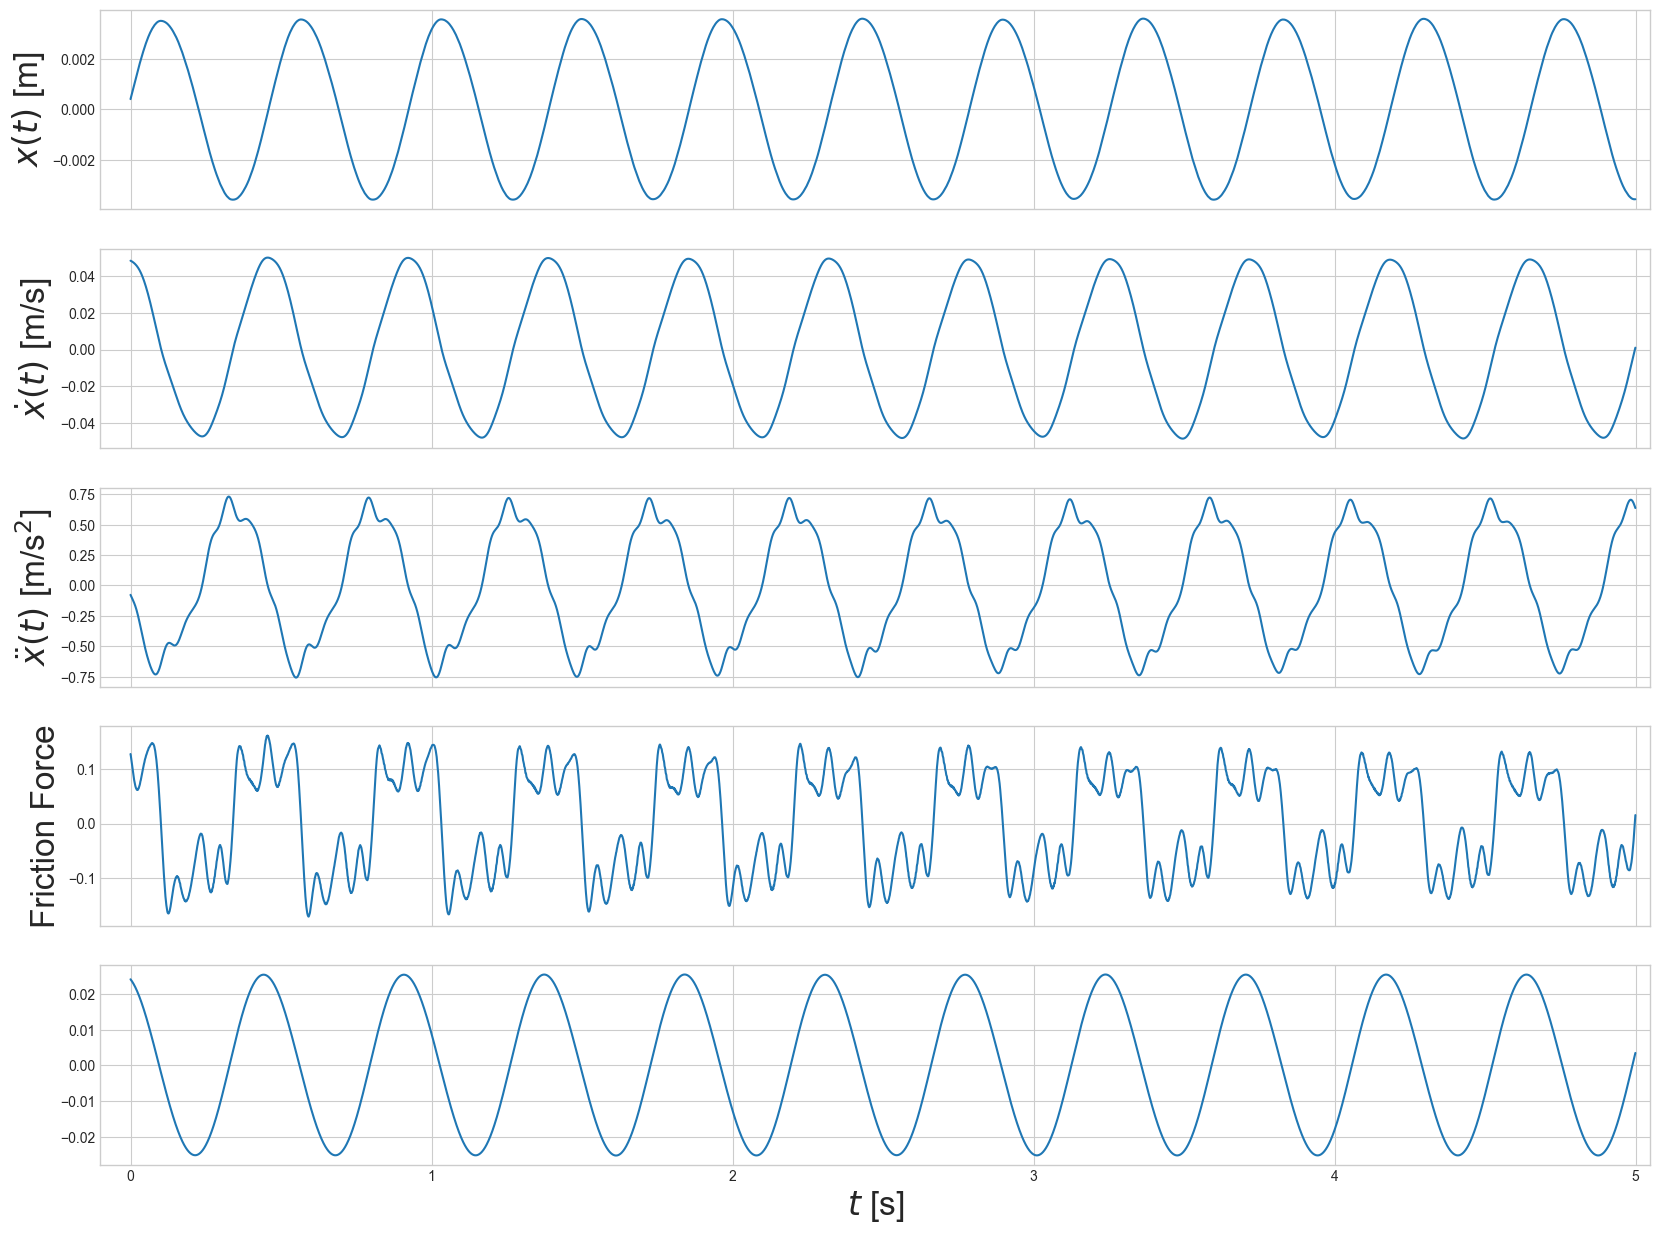

In [23]:
_, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, figsize=(20,15), sharex=True)
ax1.plot(ts, x[:, 0])
ax2.plot(ts, x[:, 1])
# ax4.plot(ts, u[:, 0])
ax5.plot(ts, u[:, 1])

_, accels = pynumdiff.linear_model.spectraldiff(vels, Params.timestep, [0.1])
accels = accels[Params.reduce_start:Params.reduce_stop:Params.reduce_step]
fricForce = 386.364 * u[:, 0] + 0.0658 * u[:, 1] - 386.364 * x[:, 0] - 0.0658 * x[:, 1] - accels

ax3.plot(ts, accels)
ax4.plot(ts, fricForce)

a = 0.07
b = 0.09
c = 0.022
F_star = 1
V_star = 0.003
eps = 1e-6

fricForce = (F_star + a * np.log((np.abs(x[:, 1]) + eps) / V_star) + b * np.log(c + V_star / (np.abs(x[:, 1]) + eps))) * np.sign(x[:, 1])
fricForce = np.where((np.abs(x[:, 1]) <= 2e-3), (386.7 * u[:, 0] + 0.2172 * u[:, 1] - 386.7 * x[:, 0]), fricForce)

# ax5.plot(ts, fricForce)

plt.xlabel(r"$t$ [s]", fontsize=24)
ax1.set_ylabel(r"$x(t)$ [m]", fontsize=24)
ax2.set_ylabel(r"$\dot{x}(t)$ [m/s]", fontsize=24)
ax3.set_ylabel(r"$\ddot{x}(t)$ [m/s$^2$]", fontsize=24)
ax4.set_ylabel(r"Friction Force", fontsize=24)
ax1.set_xlim((-0.1, 1.01 * ts[-1]))
ax2.set_xlim((-0.1, 1.01 * ts[-1]))
ax3.set_xlim((-0.1, 1.01 * ts[-1]))
ax4.set_xlim((-0.1, 1.01 * ts[-1]))
plt.show()

In [24]:
def rk4th_onestep(model, x_, u_, u_mid, u_n, t_, ksis, params, timestep=1e-2):
    k1 = model(x_, u_, t_, ksis, params)
    k2 = model(x_ + 0.5 * timestep * k1, u_mid, t_ + 0.5 * timestep, ksis, params)
    k3 = model(x_ + 0.5 * timestep * k2, u_mid, t_ + 0.5 * timestep, ksis, params)
    k4 = model(x_ + 1.0 * timestep * k3, u_n, t_ + 1.0 * timestep, ksis, params)
    return x_ + (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4) * timestep

In [25]:
def true_model(xx, uu, tt, ksis, params):
    if (np.abs(xx[1]) < 1e-4) and (np.abs(386.36 * uu[0] + 0.0658 * uu[1] - 386.36 * xx[0]) <= 0.0856):
    # if (np.abs(xx[1]) < 1e-4) and (np.abs(386.766 * uu[0] - 0.0658 * uu[1] - 386.766 * xx[0]) <= 0.0856):
    # if (np.abs(xx[1]) < 1e-5) and (np.abs(358.706 * uu[0] + 0.0658 * uu[1] - 348.706 * xx[0]) <= 0.075):
        return np.array([0, 0])
    else:
        return np.array([xx[1], 
                        - 386.36 * xx[0]
                        - 0.0658 * xx[1]
                        + 386.36 * uu[0]
                        + 0.0658 * uu[1]
                        # - (0.0856 + 0.07 * np.log(np.abs(xx[1]) / np.abs(xx[1].max())))* np.sign(xx[1])], dtype=object)
                        - 0.0856 * np.sign(xx[1])], dtype=object)

In [26]:
learned_points_GT = np.zeros_like(x)
learned_points_GT[0] = Params.x0
u_middle = 0.5 * (u[:-1] + u[1:])

for k, (t_, u_1, u_m, u_2) in enumerate(zip(ts[1:], u[:-1], u_middle, u[1:]), start=1):
    learned_points_GT[k] = rk4th_onestep(true_model, learned_points_GT[k-1], u_1, u_m, u_2, t_, (), Params, timestep=Params.timestep * Params.reduce_step)

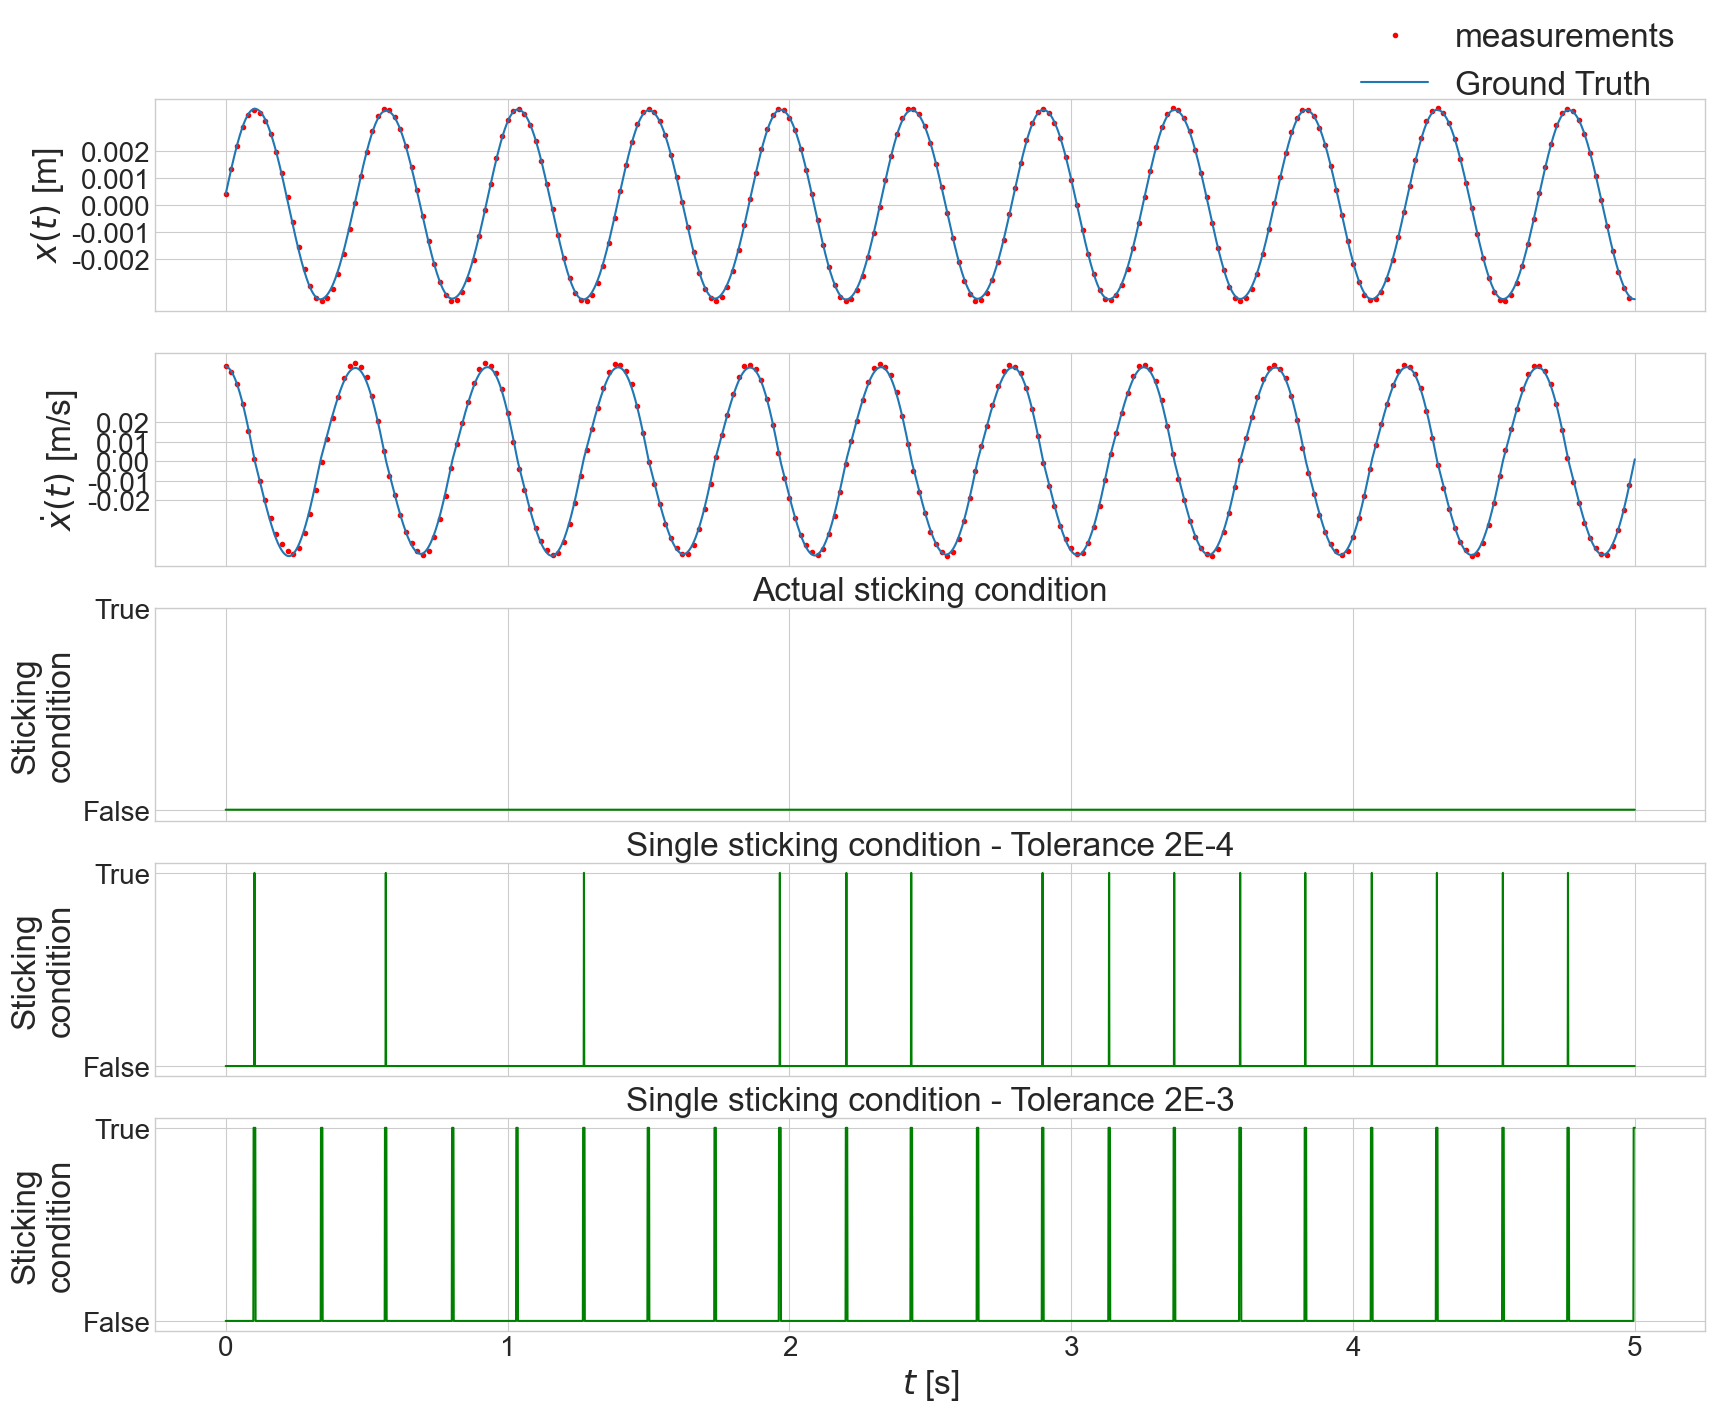

In [27]:
_, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, figsize=(20,16), sharex=True)
# _, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(20,12), sharex=True)
ax1.plot(ts[::20], x[::20, 0],"ro", markersize=3, label='measurements')
ax2.plot(ts[::20], x[::20, 1],"ro", markersize=3, label='measurements')
ax1.plot(ts, learned_points_GT[:, 0], label='Ground Truth')
ax2.plot(ts, learned_points_GT[:, 1], label='Ground Truth')
condition = np.where((np.abs(x[:, 1]) <= 1e-5) & (np.abs(386.364 * u[:, 0]+ 0.0658 * u[:, 1] - 386.364 * x[:, 0]) <= 0.0856), 1., 0.)
condition_2 = np.where((np.abs(x[:, 1]) <= 2e-4), 1., 0.)
condition_3 = np.where((np.abs(x[:, 1]) <= 2e-3), 1., 0.)
ax2.legend(fontsize=24, bbox_to_anchor=(1., 2.7))
ax3.plot(ts, condition, c='g')
ax3.set_title('Actual sticking condition', fontsize=24)
ax4.set_title("Single sticking condition - Tolerance 2E-4", fontsize=24)
ax5.set_title("Single sticking condition - Tolerance 2E-3", fontsize=24)
ax4.plot(ts, condition_2, c='g')
ax5.plot(ts, condition_3, c='g')
ax3.set_ylabel(f"Sticking\ncondition", fontsize=24)
ax3.set_yticks([0, 1])
ax4.set_ylabel(f"Sticking\ncondition", fontsize=24)
ax4.set_yticks([0, 1])
ax5.set_ylabel(f"Sticking\ncondition", fontsize=24)
ax5.set_yticks([0, 1])
ax3.set_yticklabels(['False', 'True'],fontsize=20)
ax4.set_yticklabels(['False', 'True'],fontsize=20)
ax5.set_yticklabels(['False', 'True'],fontsize=20)
ax2.set_yticks(np.arange(-0.020, 0.021, 0.010))
ax2.set_yticklabels(np.arange(-0.020, 0.021, 0.010),fontsize=20)
ax1.set_yticks(np.arange(-0.0020, 0.0021, 0.0010))
ax1.set_yticklabels(np.arange(-0.0020, 0.0021, 0.0010),fontsize=20)
# ax4.plot(ts, condition_3)
plt.xlabel(r"$t$ [s]", fontsize=24)
ax1.set_ylabel(r"$x(t)$ [m]", fontsize=24)
ax2.set_ylabel(r"$\dot{x}(t)$ [m/s]", fontsize=24)
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# ax1.set_xlim((-0.1, 1.01 * ts[-1]))
# ax2.set_xlim((-0.1, 1.01 * ts[-1]))
plt.show()

In [28]:
Params.stick_tol = 2e-4

In [31]:
386.36-179.575

206.78500000000003

In [32]:
12.035 + 0.0658

12.1008

In [33]:
Params.F0

0.7217061092983779

### Learn sparse solution

In [108]:
for _ in range(num_real):
    # increment the id of the run
    Params.id = str(int(Params.id) + 1)
        
    if Params.scaling:
        Params.mus = T.tensor(np.mean(x, axis=0)).float().unsqueeze(0)
        Params.stds = T.tensor(np.std(x, axis=0)).float().unsqueeze(0)

    # Learn the coefficients
    train_dset = T.tensor(x).float()
    excitation_dset = T.tensor(u).float()
    times = T.tensor(ts).unsqueeze(1).float()

    no_of_terms = apply_features(train_dset[:2], times[:2], params=Params).shape[1]

    coeffs = CoeffsDictionary(no_of_terms)

    # Learning Coefficients
    coeffs, loss_track = learn_sparse_model(coeffs, train_dset, excitation_dset, times, Params, lr_reduction=10)
    learnt_coeffs = coeffs.linear.weight.detach().clone().t().numpy()

    Params.equation = print_learnt_equation(learnt_coeffs, Params)

    print(f"\n\n{'-' * len(Params.equation)}\n{'The learnt equation is:'.center(len(Params.equation))}\n{Params.equation}\n{'-' * len(Params.equation)}")

 [Iter 4/4] [Epoch 2000/2000] [Training loss: 3.23e-06] [Learning rate: 1.00e-03]

----------------------------------
     The learnt equation is:      
-0.102 sgn(y) +179.575 x -12.035 y
----------------------------------


In [67]:
learnt_coeffs

array([[  0.        ],
       [  0.        ],
       [  3.418671  ],
       [ -0.        ],
       [ -0.        ],
       [ -0.11978009],
       [ -0.        ],
       [ 81.01751   ],
       [-66.81122   ]], dtype=float32)

In [109]:
def learnt_model(xx, uu, tt, ksis, params):
    identified = (apply_features(np.expand_dims(xx, axis=0), tt, params=params, torch_flag=False) @ ksis).item()
    # if (np.abs(xx[1]) < params.stick_tol) and (np.abs(386.364 * uu[0] + 0.0658 * uu[1] - 386.364 * xx[0]) <= np.abs(identified)):
    # if (np.abs(xx[1]) < 1e-8) and (np.abs(386.36 * uu[0] + 0.0658 * uu[1] - 386.36 * xx[0]) <= np.abs(identified)):
    # if (np.abs(xx[1]) < 1e-5) and (np.abs(358.706 * uu[0] + 0.0658 * uu[1] - 358.706 * xx[0]) <= 0.0856):
        # return np.array([0, 0])
    # else:
    return np.array([xx[1], 
                    - 386.36 * xx[0]
                    - 0.0658 * xx[1]
                    # + 386.36 * uu[0]
                    # + 0.0658 * uu[1] 
                    # + identified * np.sign(xx[1])], dtype=float)
                    + params.F0 * np.cos(params.forcing_freq * tt)
                    + identified], dtype=float)

In [110]:
learned_points_DR = np.zeros_like(x)
# learned_points_C = np.zeros_like(x)
learned_points_GT = np.zeros_like(x)
learned_points_DR[0] = Params.x0
# learned_points_C[0] = Params.x0
learned_points_GT[0] = Params.x0
u_middle = 0.5 * (u[:-1] + u[1:])

for k, (t_, u_1, u_m, u_2) in enumerate(zip(ts[1:], u[:-1], u_middle, u[1:]), start=1):
    learned_points_GT[k] = rk4th_onestep(true_model, learned_points_GT[k-1], u_1, u_m, u_2, t_, learnt_coeffs, Params, timestep=Params.timestep * Params.reduce_step)
for k, (t_, u_1, u_m, u_2) in enumerate(zip(ts[1:], u[:-1], u_middle, u[1:]), start=1):
    learned_points_DR[k] = rk4th_onestep(learnt_model, learned_points_DR[k-1], u_1, u_m, u_2, t_, learnt_coeffs, Params, timestep=Params.timestep * Params.reduce_step)
# for k, (t_, u_1, u_m, u_2) in enumerate(zip(ts[1:], u[:-1], u_middle, u[1:]), start=1):
    # learned_points_C[k] = rk4th_onestep(learnt_model, learned_points_C[k-1], u_1, u_m, u_2, t_, learnt_coeffs_Coulomb, Params, timestep=Params.timestep * Params.reduce_step)

In [111]:
fsize = 11
tsize = 18

tdir = 'in'

major = 5.0
minor = 3.0

style = 'default'

plt.style.use(style)
plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 300
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor

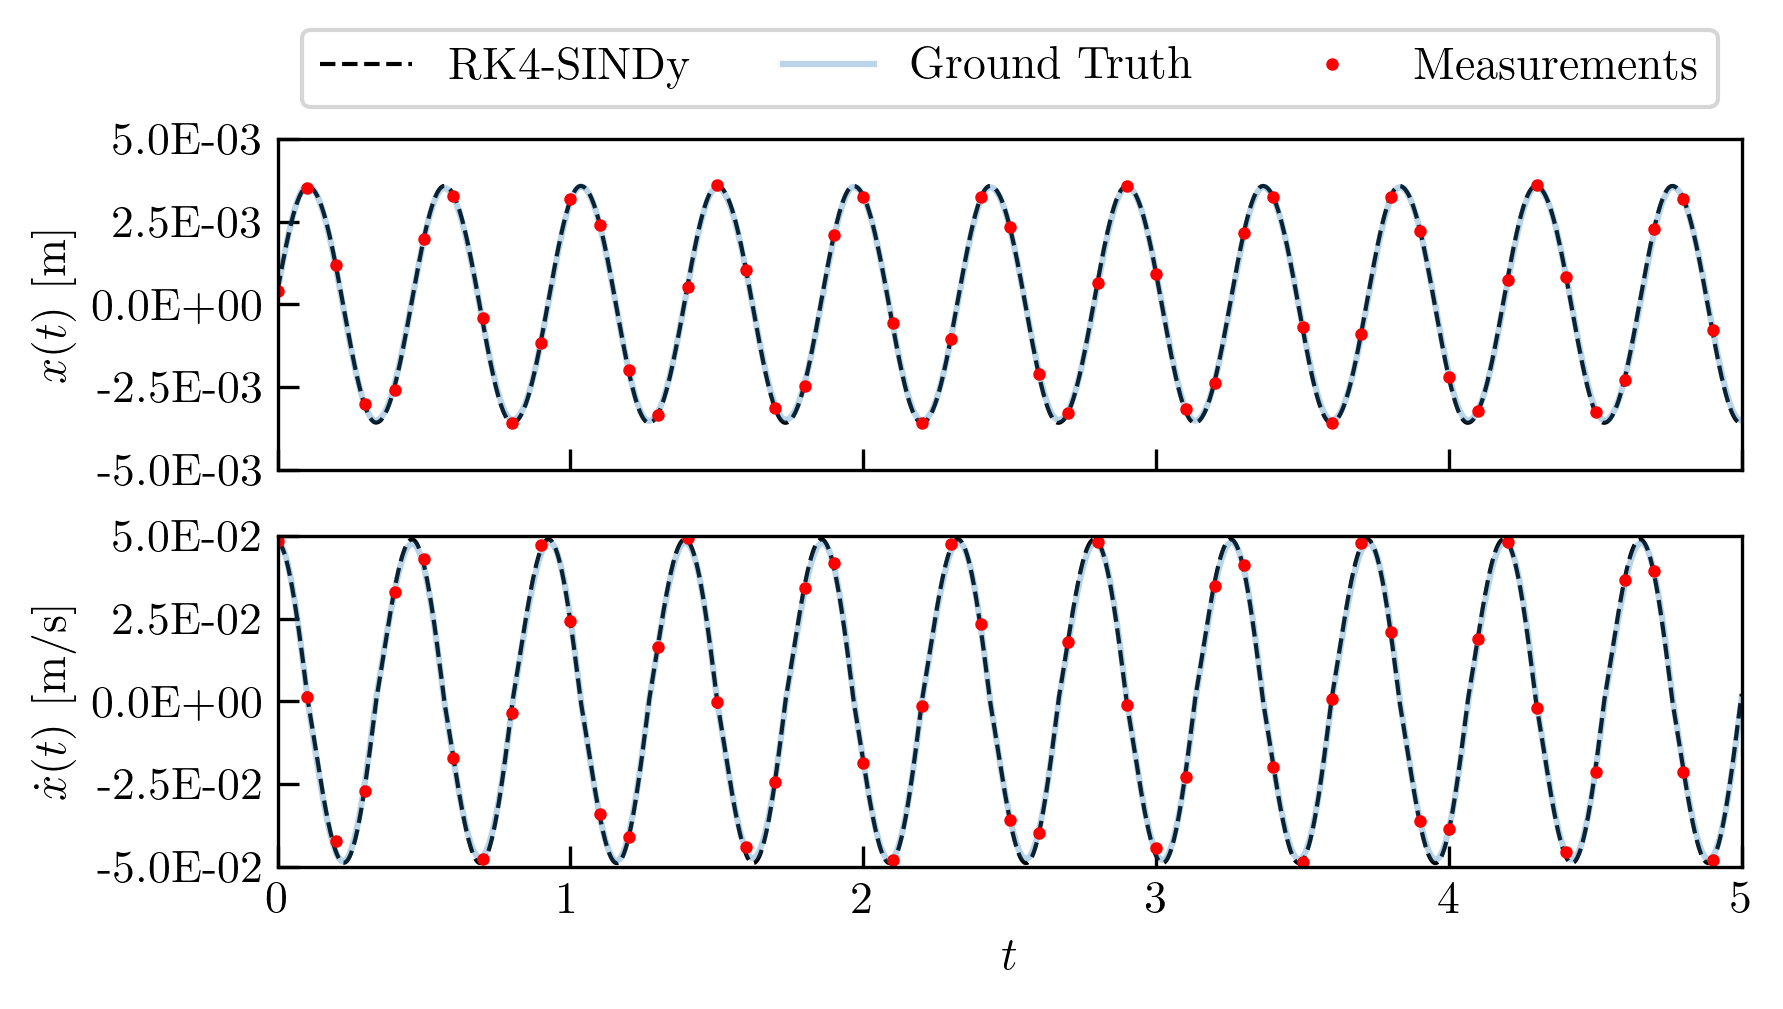

In [112]:
cm = 1/2.54
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16*cm,8*cm), sharex=True)

ax1.plot(ts, learned_points_DR[:, 0], "k--", linewidth=1, label='RK4-SINDy')
# ax1.plot(ts, learned_points_C[:, 0], "k--", linewidth=2, label='RK4-SINDy_Coulomb')
ax1.plot(ts, learned_points_GT[:, 0], linewidth=1.5, alpha=0.3, label='Ground Truth')
ax1.plot(ts[::100], x[::100, 0], "ro", markersize=2, label='Measurements')
ax2.plot(ts, learned_points_DR[:, 1], "k--", linewidth=1, label='RK4-SINDy')
# ax2.plot(ts, learned_points_C[:, 1], "k--", linewidth=2, label='RK4-SINDy_Coulomb')
ax2.plot(ts, learned_points_GT[:, 1], linewidth=1.5, alpha=0.3, label='Ground Truth')
ax2.plot(ts[::100], x[::100, 1], "ro", markersize=2, label='Measurements')

plt.xlabel("$t$")
ax1.set_ylabel("$x(t)$ [m]")
ax2.set_ylabel("$\dot{x}(t)$ [m/s]")


ax2.set_xticks(np.arange(0, 5.1, 1), np.arange(0, 5.1, 1))
ax1.set_yticks(np.arange(-0.005, 0.0051, 0.0025),np.arange(-0.005, 0.0051, 0.0025))
ax2.set_yticks(np.arange(-0.05, 0.051, 0.025),np.arange(-0.05, 0.051, 0.025))
# ax1.set_yticks(np.arange(-0.002, 0.0021, 0.001),np.arange(-0.002, 0.0021, 0.001))
# ax2.set_yticks(np.arange(-0.015, 0.016, 0.015),np.arange(-0.015, 0.016, 0.015))

ax1.set_ylim((-0.005, 0.005))
ax2.set_ylim((-0.05, 0.05))
# ax1.set_ylim((-0.002, 0.002))
# ax2.set_ylim((-0.015, 0.015))
ax2.set_xlim((0, 5))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 2.6), ncols=3, fontsize=fsize)

ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1E}')) 
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1E}')) 
ax2.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

plt.show()

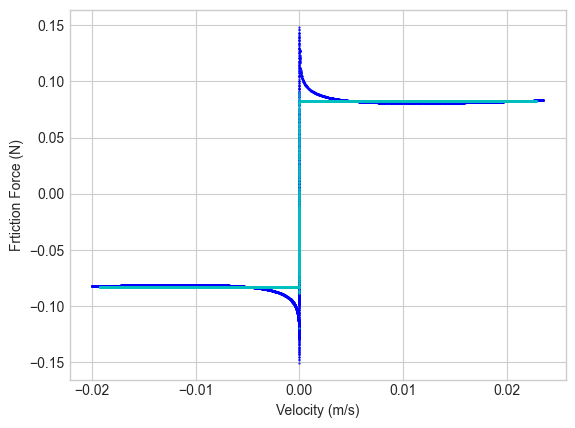

In [198]:
friction_DR = -(apply_features(learned_points_DR, times, params=Params, torch_flag=False) @ learnt_coeffs.squeeze(1)) * np.sign(learned_points_DR[:, 1])
friction_DR = np.where(np.abs(learned_points_DR[:, 1]) <= 1e-5, 386.7 * u[:, 0] + 0.2172 * u[:, 1] - 386.7 * learned_points_DR[:, 0], friction_DR)
friction_C = -(apply_features(learned_points_C, times, params=Params, torch_flag=False) @ learnt_coeffs_Coulomb.squeeze(1)) * np.sign(learned_points_C[:, 1])
friction_C = np.where(np.abs(learned_points_C[:, 1]) <= 1e-5, 386.7 * u[:, 0] + 0.2172 * u[:, 1] - 386.7 * learned_points_C[:, 0], friction_C)

# plt.plot(learned_points[::5, 1], friction[::5], "bo", markersize=0.5)
plt.plot(learned_points_DR[:, 1], friction_DR, "bo", markersize=0.5, )
plt.plot(learned_points_C[:, 1], friction_C, "co", markersize=0.5)
plt.xlabel("Velocity (m/s)")
plt.ylabel("Frtiction Force (N)")
plt.show()